In [3]:
from espm.weights import generate_weights as gw
from espm.models import generate_EDXS_phases as edx
from espm.datasets import base as gen
from espm.conf import DATASETS_PATH
from espm.estimators.smooth_nmf import SmoothNMF
from espm.measures import find_min_config
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from espm.utils import rescaled_DH

# Generate the distribution of phases

The generated phases are two spherical particles embedded in a matrix material. The seed was chosen so that both particles are fully inside the field of view and there is some small overlap between the particles.

In [2]:
spheres = gw.generate_weights("sphere", [128,128],3,6549, radius =25.0)

## Plot the distribution of the phases

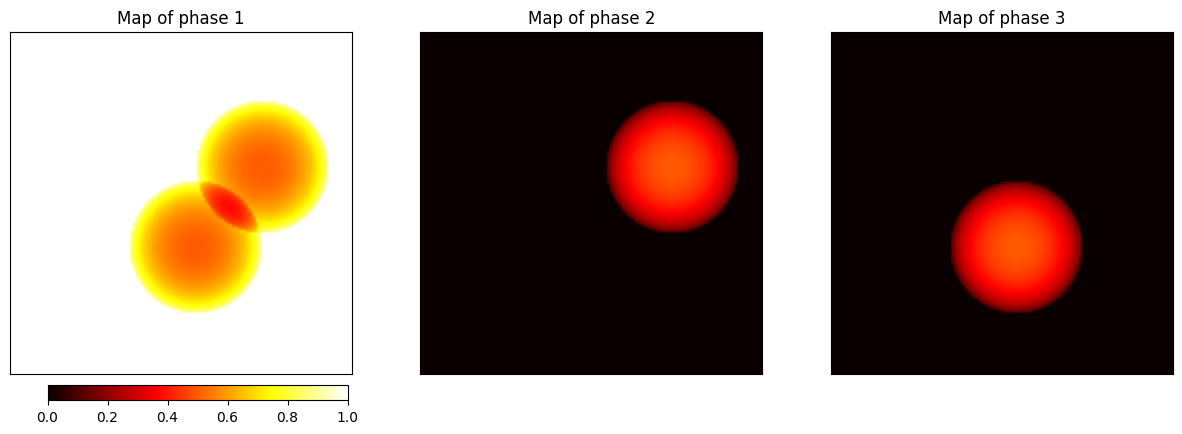

In [3]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
cax = fig.add_axes([0.15, 0.1, 0.2, 0.03])
for i,weight in enumerate(spheres.T):
    im = ax[i].imshow(weight[:,:], cmap = 'hot', vmin = 0.0, vmax = 1.0)
    ax[i].set_title("Map of phase {}".format(i+1))
    ax[i].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
fig.colorbar(im, cax=cax, orientation='horizontal')

# Generate the spectra of the phases

The matrix corresponds to a pseudo-bridgmanite while the two other phases correspond to pseudo-Ca-perovsite and pseudo-ferropericlase.

In [4]:
elts_dicts = [
    {
        "Mg" : 0.245, "Fe" : 0.035, "Ca" : 0.031, "Si" : 0.219, "Al" : 0.024, "O" : 0.436, "Cu" : 0.05, "Hf" : 0.01
    },
    {
        "Mg" : 0.522, "Fe" : 0.104, "O" : 0.374, "Cu" : 0.05
    },
    {
        "Mg" : 0.020, "Fe" : 0.018, "Ca" : 0.188, "Si" : 0.173, "Al" : 0.010, "O" : 0.572, "Ti" : 0.004, "Cu" : 0.05, "Sm" : 0.007, "Lu" : 0.006, "Nd" : 0.006 
    }]

brstlg_pars = [
    {"b0" : 0.0003458, "b1" : 0.0006268},
    {"b0" : 0.0001629, "b1" : 0.0009812},
    {"b0" : 0.0007853, "b1" : 0.0003658}
]

model_params = {
        "e_offset" : 0.3,
        "e_size" : 1980,
        "e_scale" : 0.01,
        "width_slope" : 0.01,
        "width_intercept" : 0.065,
        "db_name" : "200keV_xrays.json",
        "E0" : 200,
        "params_dict" : {
            "Abs" : {
                "thickness" : 100.0e-7,
                "toa" : 35,
                "density" : 4.5,
                "atomic_fraction" : False
            },
            "Det" : "SDD_efficiency.txt"
        }
    }

phases = edx.generate_modular_phases (elts_dicts = elts_dicts, brstlg_pars = brstlg_pars, scales = [1,1,1], model_params = model_params, seed = 0)

## Plot the spectra of the phases

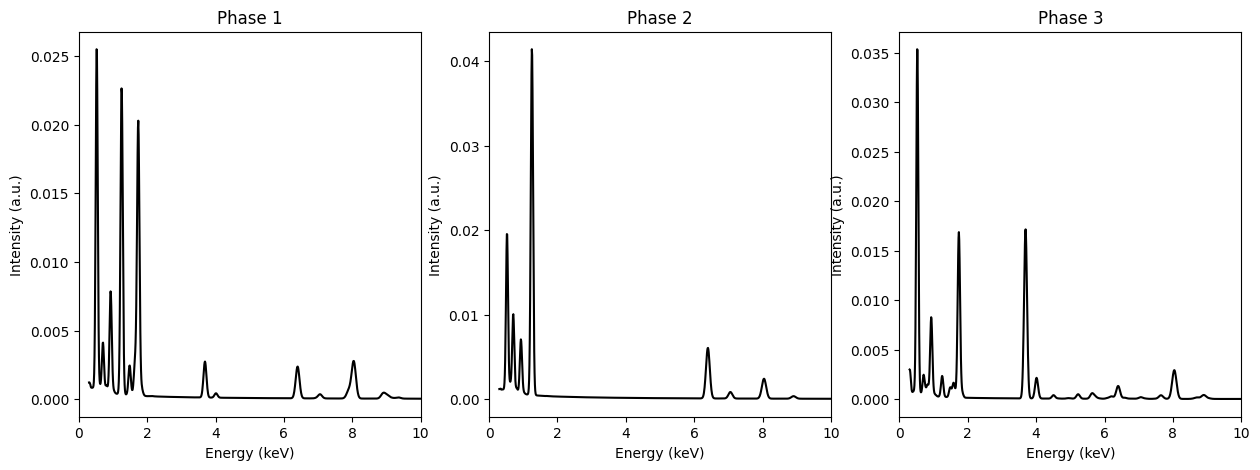

In [5]:
x = np.linspace(model_params["e_offset"], model_params["e_offset"] + model_params["e_size"]*model_params["e_scale"], model_params["e_size"])
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in range(3):  
    ax[i].plot(x,phases[i],'k')
    ax[i].set_title("Phase {}".format(i+1))
    ax[i].set_ylabel("Intensity (a.u.)")
    ax[i].set_xlim([0,10])
    ax[i].set_xlabel("Energy (keV)")

# Generate the data

The datacubes are generated as tensorial product of the phases by the maps.

## Generate the low noise data

A N = 293 is chosen to create a dataset with a strong signal to noise ratio. N = 293 means that in average (modulated by the densities, see misc_params) the number of counts per spectrum in the datacube is 293.

In [6]:
misc_params = {
    "data_folder" : "spheres_paper_N293",
    "shape_2d" : (128,128),
    "N" : 293,
    "densities" : [1.0,0.8,1.2],
    "model" : "EDXS",
    "seed" : 42
}
    
gen.generate_dataset(phases, spheres, model_params, misc_params, sample_number=5, base_seed = 42,
                      elements = ["O","Ca","Si","Fe","Mg","Al","Cu","Hf","Ti","Sm","Lu","Nd"])

100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


## Generate the high noise data

Here N = 18.

In [7]:
misc_params = {
    "data_folder" : "spheres_paper_N18",
    "shape_2d" : (128,128),
    "N" : 18,
    "densities" : [1.0,0.8,1.2],
    "model" : "EDXS",
    "seed" : 42
}
    
gen.generate_dataset(phases, spheres, model_params, misc_params, sample_number=5, base_seed = 42,
                      elements = ["O","Ca","Si","Fe","Mg","Al","Cu","Hf","Ti","Sm","Lu","Nd"])

100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


# Analysis of the synthetic datacubes

## Analysis of the low noise data

### Load the generated data
We immediately copy the data so that we can perform the decomposition twice. Once with the espm implementation of NMF and once with the scikit-learn implementation of NMF. We make two copies of espm_EDS objects because the decomposition method of hyperspy overwrites the analysed spectrum image. 

In [8]:
espm_decomp_spim = hs.load(str(DATASETS_PATH) + "/spheres_paper_N293/sample_0.hspy")
espm_decomp_spim.change_dtype("float64")

scikit_decomp_spim = espm_decomp_spim.deepcopy()

### Generate the G matrix

The ```build_G``` function instensiate the G attribute. This attribute contains the G matrix used to perform the physics-based decomposition.

In [ ]:
espm_decomp_spim.build_G()

### Create the estimators objects to run the algorithms

#### espm implementation

Using the ```SmoothNMF``` object you can input all the parameters to perform your decomposition with the same framework as the scikit-learn one. For an explanation about the parameters see the documentation.

In [ ]:
espm_nmf = SmoothNMF(n_components=3,
                    G = espm_decomp_spim.G,
                    max_iter=100000,
                    tol=1e-8,
                    init = 'nndsvdar',
                    random_state = 42,
                    mu = 0.004,
                    epsilon_reg = 0.01,
                    lambda_L = 1.0,
                    shape_2d = (128,128),
                    normalize = True,
                    hspy_comp = True)

Running the espm decomposition. /!\ This will take a while. /!\

In [ ]:
espm_decomp_spim.decomposition(algorithm = espm_nmf)

### scikit-learn implementation

In [ ]:
sk_nmf = NMF(n_components=3,init='nndsvdar',max_iter=10000,tol=1e-8, random_state = 25, beta_loss='kullback-leibler', solver='mu')

Running the scikit-learn decomposition. /!\ This will take a while. /!\

In [ ]:
scikit_decomp_spim.decomposition(algorithm = sk_nmf)

### Getting the results of the decompositions

We store the output of the decompositions as well as the ground truth into series of maps and spectra. We then find which map (or spectrum) correspond to which ground ground truth using `find_min_config`.

In [ ]:
espm_decomp_maps = espm_decomp_spim.get_decomposition_loadings().data.reshape((3,128*128))
espm_decomp_spectra = espm_decomp_spim.get_decomposition_factors().data

sk_decomp_maps = scikit_decomp_spim.get_decomposition_loadings().data.reshape((3,128*128))
sk_decomp_spectra = scikit_decomp_spim.get_decomposition_factors().data

true_maps = espm_decomp_spim.maps
true_spectra = espm_decomp_spim.phases.T

espm_config = find_min_config(true_maps, true_spectra, espm_decomp_maps, espm_decomp_spectra)[2]
sk_config = find_min_config(true_maps, true_spectra, sk_decomp_maps, sk_decomp_spectra)[2]

In [ ]:


espm_decomp_spectra, espm_decomp_maps = rescaled_DH(espm_decomp_spectra.T, espm_decomp_maps)
sk_decomp_spectra, sk_decomp_maps = rescaled_DH(sk_decomp_spectra.T, sk_decomp_maps)

In [ ]:
espm_decomp_spectra = espm_decomp_spectra.T
sk_decomp_spectra = sk_decomp_spectra.T

### Plotting the results

In [ ]:
fig, axs = plt.subplots(3,4,figsize=(15,9), width_ratios=[1,1,1,3])
cax = fig.add_axes([0.23, 0.08, 0.2, 0.01])
for i in range(3) :  
        im = axs[i,0].imshow(true_maps[i].reshape((128,128)),cmap='hot', vmin = 0, vmax = 1, aspect = 'auto')
        axs[i,0].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        axs[i,1].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        axs[i,2].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        axs[0,0].set_title("Ground truth")
        axs[i,0].set_ylabel("Phase {}".format(i+1))
        axs[i,2].imshow(espm_decomp_maps[espm_config[i]].reshape((128,128)),cmap='hot',vmin = 0, vmax = 1.0, aspect = 'auto')
        axs[0,1].set_title("Scikit decomposition")
        axs[i,1].imshow(sk_decomp_maps[sk_config[i]].reshape((128,128)),cmap='hot',vmin = 0, vmax = 1.0, aspect = 'auto')
        axs[0,2].set_title("espm decomposition")
        axs[i,3].plot(x,true_spectra[i] + 10,'k', label = 'Ground truth')
        axs[i,3].plot(x,sk_decomp_spectra[sk_config[i]] + 10,'r--', label = 'Scikit decomposition')
        axs[i,3].plot(x,true_spectra[i],'k')
        axs[i,3].plot(x,espm_decomp_spectra[espm_config[i]],'b--', label = 'espm decomposition')
        axs[i,3].set_xlim([0,10])
        axs[i,3].tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
        axs[i,3].set_ylabel("Intensity (a.u.)")
        axs[0,3].legend()
        axs[2,3].set_xlabel("Energy (keV)")
fig.colorbar(im, cax=cax, orientation='horizontal')

## Analysis of the high noise data

In this part we follow the same steps but with adapted decomposition parameters. With that high level of noise, the results of the decompositions obviously worsen but they show that the physics modelling helps the analysis.

Note that depending on the initial random state, the results vary a lot.

### Load the generated data

In [10]:
espm_decomp_spim_hn = hs.load(str(DATASETS_PATH) + "/spheres_paper_N18/sample_0.hspy")
espm_decomp_spim_hn.change_dtype("float64")

scikit_decomp_spim_hn = espm_decomp_spim_hn.deepcopy()

### Generate the G matrix

In [ ]:
espm_decomp_spim_hn.build_G()

### Create the estimators objects to run the algorithms

#### espm implementation

In [ ]:
espm_nmf_hn = SmoothNMF(n_components=3,
                    G = espm_decomp_spim_hn.G,
                    max_iter=10000,
                    tol=1e-8,
                    init = 'random',
                    random_state = 294,
                    mu = 0.000,
                    epsilon_reg = 1.0,
                    lambda_L = 0.0,
                    shape_2d = (128,128),
                    normalize = True, hspy_comp = True)

Running the espm decomposition. /!\ This will take a while. /!\

In [ ]:
espm_decomp_spim_hn.decomposition(algorithm = espm_nmf_hn)

### scikit-learn implementation

In [ ]:
sk_nmf_hn = NMF(n_components=3,init='random',max_iter=10000,tol=1e-8, random_state = 294, beta_loss='kullback-leibler', solver='mu')

Running the scikit-learn decomposition. /!\ This will take a while. /!\

In [ ]:
scikit_decomp_spim_hn.decomposition(algorithm = sk_nmf_hn)

### Getting the results of the decompositions

In [ ]:
espm_decomp_maps_hn = espm_decomp_spim_hn.get_decomposition_loadings().data.reshape((3,128*128))
espm_decomp_spectra_hn = espm_decomp_spim_hn.get_decomposition_factors().data

sk_decomp_maps_hn = scikit_decomp_spim_hn.get_decomposition_loadings().data.reshape((3,128*128))
sk_decomp_spectra_hn = scikit_decomp_spim_hn.get_decomposition_factors().data

true_maps_hn = espm_decomp_spim_hn.maps
true_spectra_hn = espm_decomp_spim_hn.phases.T

espm_config_hn = find_min_config(true_maps_hn, true_spectra_hn, espm_decomp_maps_hn, espm_decomp_spectra_hn, angles = False)[2]
sk_config_hn = find_min_config(true_maps_hn, true_spectra_hn, sk_decomp_maps_hn, sk_decomp_spectra_hn, angles = False)[2]

In [ ]:
from espm.utils import rescaled_DH

espm_decomp_spectra_hn, espm_decomp_maps_hn = rescaled_DH(espm_decomp_spectra_hn.T, espm_decomp_maps_hn)
sk_decomp_spectra_hn, sk_decomp_maps_hn = rescaled_DH(sk_decomp_spectra_hn.T, sk_decomp_maps_hn)

espm_decomp_spectra_hn = espm_decomp_spectra_hn.T
sk_decomp_spectra_hn = sk_decomp_spectra_hn.T

In [ ]:
tm = true_maps_hn.reshape((3,128,128))
skm = sk_decomp_maps_hn.reshape((3,128,128))
m = espm_decomp_maps_hn.reshape((3,128,128))


In [ ]:
np.savez('N18.npz',
         tm0 = tm[0],
         tm1 = tm[1],
         tm2 = tm[2],
         skm0 = skm[0],
         skm1 = skm[1],
         skm2 = skm[2],
         m0 = m[0],
         m1 = m[1],
         m2 = m[2],
         ts0 = true_spectra_hn[0],
         ts1 = true_spectra_hn[1],
         ts2 = true_spectra_hn[2],
         ss0 = sk_decomp_spectra_hn[0],
         ss1 = sk_decomp_spectra_hn[1],
         ss2 = sk_decomp_spectra_hn[2],
         s0 = espm_decomp_spectra_hn[0],
         s1 = espm_decomp_spectra_hn[1],
         s2 = espm_decomp_spectra_hn[2])

### Plotting the results

In [ ]:
fig, axs = plt.subplots(3,4,figsize=(15,9), width_ratios=[1,1,1,3])
cax = fig.add_axes([0.23, 0.08, 0.2, 0.01])
for i in range(3) :  
        im = axs[i,0].imshow(true_maps_hn[i].reshape((128,128)),cmap='hot',vmin = 0, vmax = 1.0, aspect = 'auto')
        axs[i,0].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        axs[i,1].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        axs[i,2].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        axs[0,0].set_title("Ground truth")
        axs[i,0].set_ylabel("Phase {}".format(i+1))
        axs[i,2].imshow(espm_decomp_maps_hn[espm_config_hn[i]].reshape((128,128)),cmap='hot',vmin = 0, vmax = 1.0, aspect = 'auto')
        axs[0,1].set_title("Scikit decomposition")
        axs[i,1].imshow(sk_decomp_maps_hn[sk_config_hn[i]].reshape((128,128)),cmap='hot',vmin = 0, vmax = 1.0, aspect = 'auto')
        axs[0,2].set_title("espm decomposition")
        axs[i,3].plot(x,true_spectra_hn[i] + 2,'k', label = 'Ground truth')
        axs[i,3].plot(x,sk_decomp_spectra_hn[sk_config_hn[i]] + 2,'r--', label = 'Scikit decomposition')
        axs[i,3].plot(x,true_spectra_hn[i],'k')
        axs[i,3].plot(x,espm_decomp_spectra_hn[espm_config_hn[i]],'b--', label = 'espm decomposition')
        axs[i,3].set_xlim([0,10])
        axs[i,3].tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
        axs[i,3].set_ylabel("Intensity (a.u.)")
        axs[0,3].legend()
        axs[2,3].set_xlabel("Energy (keV)")
fig.colorbar(im, cax=cax, orientation='horizontal')

# Analysis of the experimental datacubes

## Aim of the study

In this part of the notebook we will perform a similar analysis as in the paper of D. Rossouw et al. (see below) but using the espm package instead.

In the work of D. Rossouw et al., they synthesized core-shell nanoparticles with a core of FePt alloy and a shell of Fe3O4. They also synthesized bare cores of their FePt alloy. Both samples were observed in the STEM, resulting in two STEM-EDX spectrum images. Since, in a typical nanoparticle, the shell is all around the core the EDXS signals are mixed between the core and the shell. In their paper, they successfully used ICA to disentangle the contributions from the core and from the shell. They used the bare cores to check the quality of their analysis. 

The work of D. Roussouw et al. can be cited as follow

```
@article{rossouw2015multicomponent,
  title={Multicomponent signal unmixing from nanoheterostructures: overcoming the traditional challenges of nanoscale X-ray analysis via machine learning},
  author={Rossouw, David and Burdet, Pierre and de la Peña, Francisco and Ducati, Caterina and Knappett, Benjamin R and Wheatley, Andrew EH and Midgley, Paul A},
  journal={Nano letters},
  volume={15},
  number={4},
  pages={2716--2720},
  year={2015},
  publisher={ACS Publications}
}
```

## Our method

- We will first estimate the composition of the bare cores using our NMF method and that we retrieve a composition close to the nominal one.

- We will then try our NMF implementation on the core shells without prior knowledge and show that the NMF decomposition is not adapted to this problem.

- Finally we will show that using prior knowledge (gathered from the bare cores) we obtain a correct decomposition of the core shell dataset.

## Downloading the data

It should be done only once.

In [ ]:
#Download the data (1MB)
from urllib.request import urlretrieve, urlopen
from zipfile import ZipFile
files = urlretrieve("https://www.dropbox.com/s/ecdlgwxjq04m5mx/HyperSpy_demos_EDS_TEM_files.zip?raw=1", "./HyperSpy_demos_EDX_TEM_files.zip")
with ZipFile("HyperSpy_demos_EDX_TEM_files.zip") as z:
    z.extractall()

## Loading the data 

Three signals are created for this notebook : 
- `bare_core` from the bare cores dataset
- `core_shell_i` from the core shell dataset for the initial NMF decomposition
- `core_shell_f` from the core_shell dataset for the NMF decomposition with prior knowledge 

For all the dataset, the relevant metadata and data types are set before the analysis by NMF.

Note that we add all elements, even Cu, present in the spectrum images for a better fit.

In [10]:
# Loading
core_shell_i = hs.load('core_shell.hdf5')
core_shell_f = hs.load('core_shell.hdf5')
bare_core = hs.load('bare_core.hdf5')

# Setting signal type and dtype
core_shell_i.set_signal_type('EDS_espm')
core_shell_f.set_signal_type('EDS_espm')
bare_core.set_signal_type('EDS_espm')

core_shell_i.change_dtype('float')
core_shell_f.change_dtype('float')
bare_core.change_dtype('float')

# Setting the metadata
core_shell_i.set_additional_parameters(
    thickness=2e-05,
    density=3.5,
    detector_type='SDD_efficiency.txt',
    width_slope=0.01,
    width_intercept=0.065,
    xray_db='200keV_xrays.json'
    )
core_shell_i.add_elements(elements = ['Fe', 'Pt', 'O', 'Si', 'C', 'Cu'])

core_shell_f.set_additional_parameters(
    thickness=2e-05,
    density=3.5,
    detector_type='SDD_efficiency.txt',
    width_slope=0.01,
    width_intercept=0.065,
    xray_db='200keV_xrays.json'
    )
core_shell_f.add_elements(elements = ['Fe', 'Pt', 'O', 'Si', 'C', 'Cu'])

bare_core.set_additional_parameters(
    thickness=2e-05,
    density=3.5,
    detector_type='SDD_efficiency.txt',
    width_slope=0.01,
    width_intercept=0.065,
    xray_db='200keV_xrays.json'
    )
bare_core.add_elements(elements = ['Fe', 'Pt', 'O', 'Si', 'C', 'Cu'])

/home/adrien/anaconda3/envs/espm_dev/lib/python3.11/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/adrien/anaconda3/envs/espm_dev/lib/python3.11/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


## Bare cores analysis

In this part we build G from the metadata. Set the parameters for the algorithm. Then we run the algorithm and plot its results.

### Building G

Note that we split the Cu in two parts. The absorption of Cu is very hard to take into account properly and thus the K and L lines are decoupled to obtain a better fit. 

In [ ]:
bare_core.build_G('bremsstrahlung', reference_elt = {'29' : 3.0})

### Setting the parameters of the algorithm

There is only two components, the cores and the membrane on which they are observed

In [ ]:
bare_core_est = SmoothNMF(n_components=2,
                    G = bare_core.G,
                    hspy_comp = True)

### Running the algorithm for the bare cores

In [ ]:
bare_core.decomposition(algorithm = bare_core_est)

## Getting the results

### Plot the results

In [ ]:
bare_core_maps = bare_core.get_decomposition_loadings()
bare_core_spectra = bare_core.get_decomposition_factors()

# energy scale
x = np.linspace(
    bare_core.axes_manager.signal_axes[0].offset,
    bare_core.axes_manager.signal_axes[0].offset + bare_core.axes_manager.signal_axes[0].scale * bare_core.axes_manager.signal_axes[0].size,
    bare_core.axes_manager.signal_axes[0].size
)


fig, axs = plt.subplots(2,2,figsize=(15,9), width_ratios=[1,3])
cax = fig.add_axes([0.13, 0.08, 0.17, 0.01])
for i in range(2) :  
        im = axs[i,0].imshow(bare_core_maps.data[i],cmap='hot',vmin = 0, aspect = 'auto')
        axs[i,1].plot(x, bare_core_spectra.data[i])
        axs[i,0].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        axs[i,1].set_xlim([0,14])
        axs[i,1].tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
        axs[i,1].set_ylabel("Intensity (a.u.)")
        axs[1,1].set_xlabel("Energy (keV)")

scalebar = AnchoredSizeBar(axs[1,0].transData,
                           20, '{} {}'.format(20*bare_core.axes_manager[0].scale, bare_core.axes_manager[0].units),
                           'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)

axs[1,0].add_artist(scalebar)

fig.colorbar(im, cax=cax, orientation='horizontal')

### Quantification of the bare cores

#### Full quantification

There are two phases, one corresponds to the membrane (almost no iron and platinum) and the other to the bare cores.

The '29_lo' and '29_hi' correspond to Cu L and K lines that are learned separetely. 

In [ ]:
bare_core.print_concentration_report()

#### Fe/Pt ratio

We can check here that the quantification find a Fe/Pt ratio for the cores that is close to the nominal one. In the following we will consider that the cores have this composition : Fe 0.14 Pt 0.86

In [ ]:
bare_core.print_concentration_report(selected_elts = ['Fe', 'Pt'])

### Checking the quality of the modelling

This plot is to check the quality of the EDS model by comparing the result of the decomposition with the experimental data.

In [ ]:
bare_core_exp = bare_core.mean()
bare_core_model = ((bare_core_spectra.data.T)@bare_core_maps.data.reshape((2,84*84))).mean(axis = 1)


fig, axs = plt.subplots(1,2, figsize = (15,6))
axs[0].plot(x, bare_core_exp,'.', label = "Experimental")
axs[0].plot(x, bare_core_model, label = "Model")
axs[0].set_xlabel("Energy (keV)")
axs[0].set_ylabel("Counts")
axs[0].legend()
axs[0].set_xlim(0,14.0)
axs[1].plot(x,bare_core_exp,'.')
axs[1].plot(x,bare_core_model)
axs[1].set_xlabel("Energy (keV)")
axs[1].set_ylabel("Counts")
axs[1].set_ylim(0,1.5)
axs[1].set_xlim(0,14.0)


## First core shell analysis

In this part we build G from the metadata. Set the parameters for the algorithm. Then we run the algorithm and plot its results.

### Building G

Note that we split the Cu in two parts. The absorption of Cu is very hard to take into account properly and thus the K and L lines are decoupled to obtain a better fit. 

In [11]:
core_shell_i.build_G('bremsstrahlung', reference_elt = {'29' : 3.0})

### Setting the parameters of the algorithm

There are three components, the cores, the shells and the membrane on which they are observed.

In [16]:
cs_i_est = SmoothNMF(n_components=3, simplex_W = False,
                    G = core_shell_i.G,
                    hspy_comp = True)

### Running the algorithm without prior knowledge

In [13]:
core_shell_i.decomposition(algorithm = cs_i_est)

It 10 / 200: loss 1.370990e-01,  5.620 it/s
exits because of relative change < tol: 8.512943486827803e-05
Stopped after 11 iterations in 0.0 minutes and 2.0 seconds.
Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SmoothNMF()
  output_dimension=None
  centre=None
scikit-learn estimator:
SmoothNMF()


## Getting the results

### Plot the results

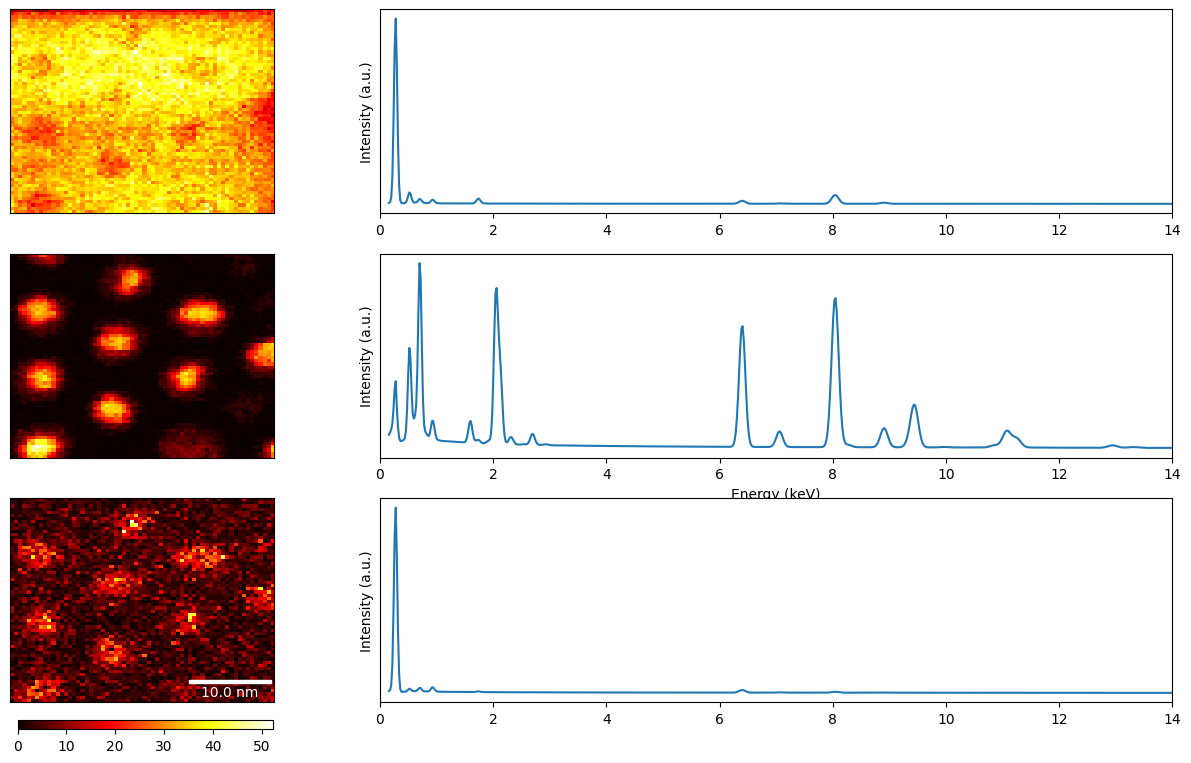

In [15]:
cs_i_maps = core_shell_i.get_decomposition_loadings()
cs_i_spectra = core_shell_i.get_decomposition_factors()

# energy scale
x = np.linspace(
    core_shell_i.axes_manager.signal_axes[0].offset,
    core_shell_i.axes_manager.signal_axes[0].offset + core_shell_i.axes_manager.signal_axes[0].scale * core_shell_i.axes_manager.signal_axes[0].size,
    core_shell_i.axes_manager.signal_axes[0].size
)


fig, axs = plt.subplots(3,2,figsize=(15,9), width_ratios=[1,3])
cax = fig.add_axes([0.13, 0.08, 0.17, 0.01])
for i in range(3) :  
        im = axs[i,0].imshow(cs_i_maps.data[i],cmap='hot',vmin = 0, aspect = 'auto')
        axs[i,1].plot(x, cs_i_spectra.data[i])
        axs[i,0].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        axs[i,1].set_xlim([0,14])
        axs[i,1].tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
        axs[i,1].set_ylabel("Intensity (a.u.)")
        axs[1,1].set_xlabel("Energy (keV)")

scalebar = AnchoredSizeBar(axs[1,0].transData,
                           20, '{} {}'.format(20*core_shell_i.axes_manager[0].scale, core_shell_i.axes_manager[0].units),
                           'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)

axs[2,0].add_artist(scalebar)

fig.colorbar(im, cax=cax, orientation='horizontal')

In [9]:
np.savez('cs_orthogonal.npz',
         om0 = cs_i_maps.data[0],
         om1 = cs_i_maps.data[1],
         om2 = cs_i_maps.data[2],
         os0 = cs_i_spectra.data[0],
         os1 = cs_i_spectra.data[1],
         os2 = cs_i_spectra.data[2])

### Short interpretation

We can see that the Fe-K peak (6.4 keV) is non-existent in two phases such that the cores are not separated from the shells. 

- There is one component for both the core and the shell.

- The other components correspond to the membrane on which the nanoparticles lie. 

Without prior knowledge, NMF fails to perform a correct decomposition.

## Second core shell analysis

In this part we build G from the metadata and set constraints on the possible values of W. Set the parameters for the algorithm. Then we run the algorithm and plot its results.

### Building G and setting fixed W

Note that we split the Cu in two parts. The absorption of Cu is very hard to take into account properly and thus the K and L lines are decoupled to obtain a better fit. 

We also initialise G such that it contains a column with a fixed ratio between different elements. In our case there will be a column with : 
Fe 0.14 Pt 0.86 .

We build a W matrix input so that there is only one phase containing the Fe0.14Pt0.86 stoichiometry, the Pt is set to 0 in the three phases so that all the Pt is fitted by the phase containing the Fe0.14Pt0.86 stoichiometry.

In [63]:
# Loading
core_shell_i = hs.load('core_shell.hdf5')
core_shell_f = hs.load('core_shell.hdf5')
bare_core = hs.load('bare_core.hdf5')

# Setting signal type and dtype
core_shell_i.set_signal_type('EDS_espm')
core_shell_f.set_signal_type('EDS_espm')
bare_core.set_signal_type('EDS_espm')

core_shell_i.change_dtype('float')
core_shell_f.change_dtype('float')
bare_core.change_dtype('float')

# Setting the metadata
core_shell_i.set_additional_parameters(
    thickness=2e-05,
    density=3.5,
    detector_type='SDD_efficiency.txt',
    width_slope=0.01,
    width_intercept=0.065,
    xray_db='200keV_xrays.json'
    )
core_shell_i.add_elements(elements = ['Fe', 'Pt', 'O', 'Si', 'C', 'Cu'])

core_shell_f.set_additional_parameters(
    thickness=2e-05,
    density=3.5,
    detector_type='SDD_efficiency.txt',
    width_slope=0.01,
    width_intercept=0.065,
    xray_db='200keV_xrays.json'
    )
core_shell_f.add_elements(elements = ['Fe', 'Pt', 'O', 'Si', 'C', 'Cu'])

bare_core.set_additional_parameters(
    thickness=2e-05,
    density=3.5,
    detector_type='SDD_efficiency.txt',
    width_slope=0.01,
    width_intercept=0.065,
    xray_db='200keV_xrays.json'
    )
bare_core.add_elements(elements = ['Fe', 'Pt', 'O', 'Si', 'C', 'Cu'])

/home/adrien/anaconda3/envs/espm_dev/lib/python3.11/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/adrien/anaconda3/envs/espm_dev/lib/python3.11/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


In [64]:
core_shell_f.build_G('bremsstrahlung', reference_elt = {'29' : 3.0}, stoichiometries = ['Fe0.14Pt0.86'])

fW = core_shell_f.set_fixed_W(
    {'background' : {'Pt' : 0.0,'Fe0.14Pt0.86' : 0.0},
    'core' : {'Pt' : 0.0, 'Fe' : 0.0, 'Si' : 0.0, 'C' : 0.0},
    'shell' : {  'Fe0.14Pt0.86' : 0.0, 'Pt' : 0.0, 'Si' : 0.0, 'C' : 0.0}})

### Setting the parameters of the algorithm

There are three components, the cores, the shells and the membrane on which they are observed. The prior knowledge is included in the computation.

In [65]:
cs_f_est = SmoothNMF(n_components=3,
                    G = core_shell_f.G,
                    fixed_W = fW,
                    simplex_W= True,
                    hspy_comp = True)

### Running the algorithm with prior knowledge

In [66]:
core_shell_f.decomposition(algorithm = cs_f_est)

It 10 / 200: loss 1.365731e-01,  5.752 it/s
exits because of relative change < tol: 8.216777463268279e-05
Stopped after 20 iterations in 0.0 minutes and 3.0 seconds.
Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SmoothNMF()
  output_dimension=None
  centre=None
scikit-learn estimator:
SmoothNMF()


In [67]:
core_shell_f.print_concentration_report(selected_elts=['Fe', 'O', 'Pt'])

Concentrations report
       p0     p1     p2
Fe : 0.1176 0.0000 0.4652 
Pt : 0.0000 0.0000 0.0000 
O  : 0.8824 1.0000 0.5348 


In [68]:
0.4223/(0.423 + 0.1920)

0.6866666666666666

## Getting the results

### Plot the results

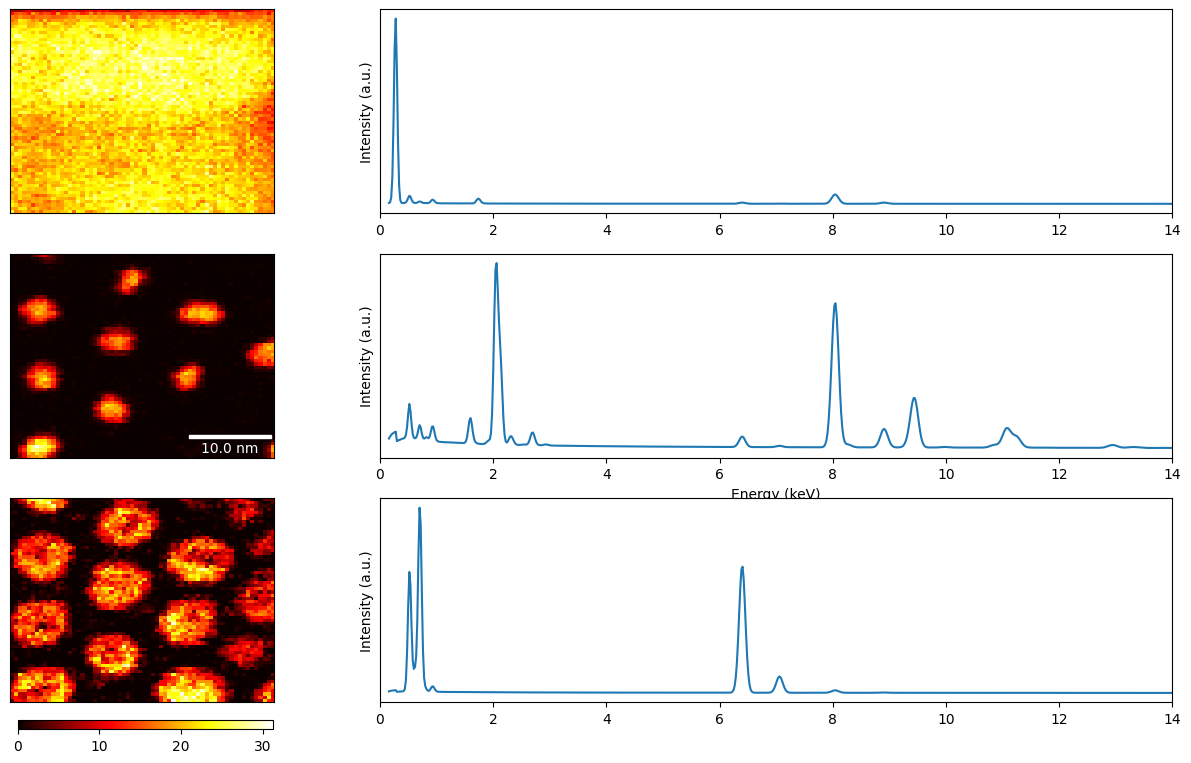

In [69]:
cs_f_maps = core_shell_f.get_decomposition_loadings()
cs_f_spectra = core_shell_f.get_decomposition_factors()

# energy scale
x = np.linspace(
    core_shell_f.axes_manager.signal_axes[0].offset,
    core_shell_f.axes_manager.signal_axes[0].offset + core_shell_f.axes_manager.signal_axes[0].scale * core_shell_f.axes_manager.signal_axes[0].size,
    core_shell_f.axes_manager.signal_axes[0].size
)


fig, axs = plt.subplots(3,2,figsize=(15,9), width_ratios=[1,3])
cax = fig.add_axes([0.13, 0.08, 0.17, 0.01])
for i in range(3) :  
        im = axs[i,0].imshow(cs_f_maps.data[i],cmap='hot',vmin = 0, aspect = 'auto')
        axs[i,1].plot(x, cs_f_spectra.data[i])
        axs[i,0].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        axs[i,1].set_xlim([0,14])
        axs[i,1].tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
        axs[i,1].set_ylabel("Intensity (a.u.)")
        axs[1,1].set_xlabel("Energy (keV)")

scalebar = AnchoredSizeBar(axs[2,0].transData,
                           20, '{} {}'.format(20*core_shell_f.axes_manager[0].scale, core_shell_f.axes_manager[0].units),
                           'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)

axs[1,0].add_artist(scalebar)

fig.colorbar(im, cax=cax, orientation='horizontal')

### Quantification of the bare cores

#### Full quantification

There are two phases, one corresponds to the membrane (almost no iron and platinum) and the other to the bare cores.

The '29_lo' and '29_hi' correspond to Cu L and K lines that are learned separetely. 

In [70]:
core_shell_f.print_concentration_report()

Concentrations report
                 p0     p1     p2
Fe           : 0.0030 0.0000 0.4560 
Pt           : 0.0000 0.0000 0.0000 
O            : 0.0221 0.1368 0.5241 
Si           : 0.0091 0.0000 0.0000 
C            : 0.9333 0.0000 0.0000 
29_lo        : 0.0042 0.0240 0.0092 
29_hi        : 0.0284 0.5903 0.0107 
Fe0.14Pt0.86 : 0.0000 0.2489 0.0000 


In [83]:
fac = core_shell_f.get_decomposition_factors().data
loads = core_shell_f.get_decomposition_loadings().data


<EDS_espm, title: Core shell, dimensions: (64, 64|992)>

In [85]:
x = np.linspace(
    core_shell_f.axes_manager.signal_axes[0].offset,
    core_shell_f.axes_manager.signal_axes[0].offset + core_shell_f.axes_manager.signal_axes[0].scale * core_shell_f.axes_manager.signal_axes[0].size,
    core_shell_f.axes_manager.signal_axes[0].size
)

In [86]:
np.savez('core_shell.npz',
            fac0 = fac[0],
            fac1 = fac[1],
            fac2 = fac[2],
            loads0 = loads[0],
            loads1 = loads[1],
            loads2 = loads[2],
            x = x)

### Shell quantification

In [75]:
core_shell_f.print_concentration_report(selected_elts = ['Fe','O'])

Concentrations report
       p0     p1     p2
Fe : 0.0863 0.0000 0.5369 
O  : 0.9137 1.0000 0.4631 


### Short interpretation

The three phases we found closely match with the results of D. Rossouw et al. 

The quantification of the Fe/O ratio of the shell is close to the expected ratio of 3/4 of the Fe3O4 phase (Fe 0.43 O 0.57).

### Checking the quality of the modelling

(0.0, 14.0)

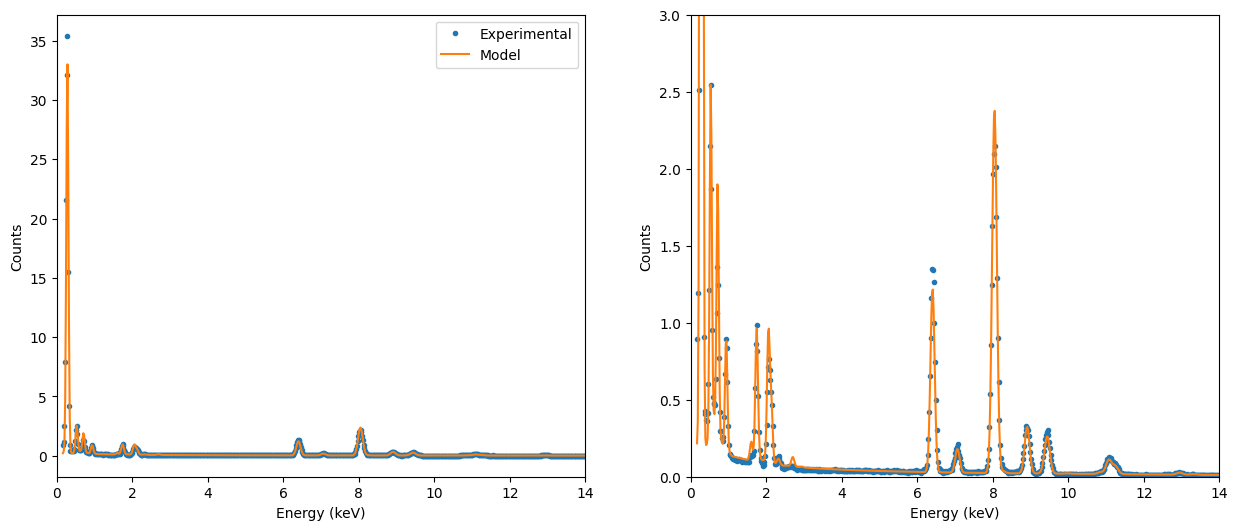

In [67]:
core_shell_exp = core_shell_f.mean()
core_shell_model = ((cs_f_spectra.data.T)@cs_f_maps.data.reshape((3,64*64))).mean(axis = 1)


fig, axs = plt.subplots(1,2, figsize = (15,6))
axs[0].plot(x, core_shell_exp,'.', label = "Experimental")
axs[0].plot(x, core_shell_model, label = "Model")
axs[0].set_xlabel("Energy (keV)")
axs[0].set_ylabel("Counts")
axs[0].legend()
axs[0].set_xlim(0,14.0)
axs[1].plot(x,core_shell_exp,'.')
axs[1].plot(x,core_shell_model)
axs[1].set_xlabel("Energy (keV)")
axs[1].set_ylabel("Counts")
axs[1].set_ylim(0,3)
axs[1].set_xlim(0,14.0)


In [87]:
np.savez('model_vs_exp.npz',
            exp = core_shell_exp,
            model = core_shell_model)

In [88]:
core_shell_f.axes_manager

Navigation axis name,size,index,offset,scale,units
x,64,0,0.0,0.5,nm
y,64,0,0.0,0.5,nm
Signal axis name,size,,offset,scale,units
Energy,992,,0.16,0.02,keV
